In [21]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
sns.set_theme()
import os

# sklearn
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# pytorch
import torch
from torch.optim import Adam
from torch import nn

# BERT from Huggingface
from transformers import BertTokenizer
from transformers import BertModel

# Extra additional packages/functions
from balancers import BinaryBalancer
from utils import calculate_bias_metrics, eo_postprocess, calc_gen_bounds, BertClassifier, train, Dataset

In [22]:
# Import fifa 20 dataset
all_data = pd.read_csv('players_20.csv')
# all_data.head()

In [23]:
# Set the nationalities you want to use
nationalities = ['England','Germany']

# Keep relevant columns
o_data = all_data[['long_name','age','nationality','overall','wage_eur']].copy(deep = True)

# Change column names of nationality and wage_eur to a and y 
o_data.rename(columns = {'nationality':'a', 'wage_eur':'y'}, inplace = True)

# Restrict to specified nationalities
o_data = o_data.loc[(o_data['a'].isin([nationalities[0], nationalities[1]]))]
print('Number of players:', o_data.shape[0])

# Only keep relevant feagires and outcomes
data = o_data[['long_name','age','a','overall','y']].copy(deep = True)

# Binarize nationality
data = data.replace(nationalities[0],0)
data = data.replace(nationalities[1],1)

# Reset the index
data = data.reset_index(drop=True)

# Binarize outcome using median outcome
data.loc[data['y'] < np.median(data['y']), 'y'] = 0
data.loc[data['y'] >= np.median(data['y']), 'y'] = 1
# data.head()

Number of players: 2883


In [24]:
# Create new column to stratify data and calculate base rates
group = []
for i in range(data.shape[0]):
    # w
    if np.sum(data[['a','y']].iloc[i] == [0,0]) == 2:
        group.append(1)
    # v
    if np.sum(data[['a','y']].iloc[i] == [1,0]) == 2:
        group.append(2)
    # s
    if np.sum(data[['a','y']].iloc[i] == [0,1]) == 2:
        group.append(3)
    # r
    if np.sum(data[['a','y']].iloc[i] == [1,1]) == 2:
        group.append(4)

# Add column to the data
data['group'] = group

# Calculate base rates
total = data.shape[0]
r = np.sum(data['group'] == 4)/total
s = np.sum(data['group'] == 3)/total
v = np.sum(data['group'] == 2)/total
w= np.sum(data['group'] == 1)/total
print('min rate = ', min(r,s,w,v))

min rate =  0.19944502254595908


In [25]:
# Experiment Parameters
EPOCHS = 10
model = BertClassifier()
LR = 1e-6 

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
# Splitting data into necessary datasets
d_xa, d_remain = train_test_split(data, train_size = 0.7, stratify=data['group'],random_state=10)

In [27]:
# Split d_xa into d_xa_train and d_xa_val
d_xa_train, d_xa_val = train_test_split(d_xa, train_size = 0.75, stratify=d_xa['group'],random_state=10)

# Train model
train(model, d_xa_train, d_xa_val, LR, EPOCHS)

100%|██████████| 757/757 [00:37<00:00, 20.02it/s]


Epochs: 1 | Train Loss:  0.657             | Train Accuracy:  0.612             | Val Loss:  0.507             | Val Accuracy:  0.873


100%|██████████| 757/757 [00:38<00:00, 19.62it/s]


Epochs: 2 | Train Loss:  0.446             | Train Accuracy:  0.858             | Val Loss:  0.359             | Val Accuracy:  0.873


100%|██████████| 757/757 [00:38<00:00, 19.87it/s]


Epochs: 3 | Train Loss:  0.338             | Train Accuracy:  0.892             | Val Loss:  0.294             | Val Accuracy:  0.887


100%|██████████| 757/757 [00:33<00:00, 22.37it/s]


Epochs: 4 | Train Loss:  0.261             | Train Accuracy:  0.919             | Val Loss:  0.284             | Val Accuracy:  0.881


100%|██████████| 757/757 [00:36<00:00, 20.67it/s]


Epochs: 5 | Train Loss:  0.200             | Train Accuracy:  0.939             | Val Loss:  0.268             | Val Accuracy:  0.891


100%|██████████| 757/757 [00:38<00:00, 19.89it/s]


Epochs: 6 | Train Loss:  0.155             | Train Accuracy:  0.955             | Val Loss:  0.273             | Val Accuracy:  0.897


100%|██████████| 757/757 [00:37<00:00, 20.14it/s]


Epochs: 7 | Train Loss:  0.136             | Train Accuracy:  0.963             | Val Loss:  0.267             | Val Accuracy:  0.901


100%|██████████| 757/757 [00:37<00:00, 20.10it/s]


Epochs: 8 | Train Loss:  0.110             | Train Accuracy:  0.971             | Val Loss:  0.287             | Val Accuracy:  0.903


100%|██████████| 757/757 [00:38<00:00, 19.63it/s]


Epochs: 9 | Train Loss:  0.091             | Train Accuracy:  0.972             | Val Loss:  0.305             | Val Accuracy:  0.901


100%|██████████| 757/757 [00:38<00:00, 19.91it/s]


Epochs: 10 | Train Loss:  0.079             | Train Accuracy:  0.980             | Val Loss:  0.316             | Val Accuracy:  0.899


In [31]:
# Check cuda
os.environ['CUDE_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")

In [32]:
# Calculating final validation accuracy and ROC curve
val = Dataset(d_xa_val)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=len(d_xa_val))
model.to(device)
model = model.eval()
with torch.no_grad():
    for val_input, val_label, val_remain in val_dataloader:
        val_label = val_label.to(device).float()
        mask = val_input['attention_mask'].to(device)
        input_id = val_input['input_ids'].squeeze(1).to(device)
        output = model(input_id, mask).reshape(1,-1)[0]

In [35]:
# Optimal Threshold for accuracy of a_hat
total_error = []
thresholds = np.linspace(0,1,500)
for t in thresholds:
    a_hat = (output.cpu() >= t)
    a_hat = a_hat.numpy().astype('int')

    # Error of h(x) on this data
    incorrect = np.sum((d_xa_val['a'] != a_hat))
    error = (incorrect)/(d_xa_val.shape[0])
    total_error.append(error)

total_error = np.array(total_error)
opt_t = thresholds[np.argmin(total_error)]
print('Optimal threshold = ', opt_t)
# plt.plot(thresholds,total_error)
# plt.xlabel('Thresholds')
# plt.ylabel('Error')
# plt.plot(thresholds,total_error)
print('Lowest error = ', np.min(total_error))

Optimal threshold =  0.03406813627254509
Lowest error =  0.0891089108910891


In [39]:
# Necessary function
def generate_estimates(t,output,d_xy_test):
    # Add a_hat column to data using opt_t
    a_hat = (output.cpu()) >= t
    d_xy_test['a_hat'] = a_hat.numpy().astype('int')

    # Error of h(x) on this data
    incorrect = np.sum((d_xy_test['a'] != d_xy_test['a_hat']))
    error = (incorrect)/(d_xy_test.shape[0])
    #print('a_error = ', error)

    y1 = d_xy_test[d_xy_test['y'] == 1]
    incorrect = np.sum(y1['a_hat'] != y1['a'])/y1.shape[0]
    U1 = incorrect*(y1.shape[0]/d_xy_test.shape[0])
    y0 = d_xy_test[d_xy_test['y'] == 0]
    incorrect = np.sum(y0['a_hat'] != y0['a'])/y0.shape[0]
    U2 = incorrect*(y0.shape[0]/d_xy_test.shape[0])

    # Evaluate the equal oppurtunity violation using a_hat using threshold of 0.5 for f
    a1_y1 = d_xy_test[(d_xy_test['a_hat'] == 1) & (d_xy_test['y'] == 1)]
    a0_y1 = d_xy_test[(d_xy_test['a_hat'] == 0) & (d_xy_test['y'] == 1)]
    a1_y0 = d_xy_test[(d_xy_test['a_hat'] == 1) & (d_xy_test['y'] == 0)]
    a0_y0 = d_xy_test[(d_xy_test['a_hat'] == 0) & (d_xy_test['y'] == 0)]
    alpha_hat = np.sum((a1_y1['y_prob'] >= 0.5) == 1)/a1_y1.shape[0]
    beta_hat = np.sum((a0_y1['y_prob'] >= 0.5) == 1)/a0_y1.shape[0]
    tau_hat = np.sum((a1_y0['y_prob'] >= 0.5) == 1)/a1_y0.shape[0]
    phi_hat = np.sum((a0_y0['y_prob'] >= 0.5) == 1)/a0_y0.shape[0]
    bias_tpr_hat = np.abs(alpha_hat - beta_hat)
    bias_fpr_hat = np.abs(tau_hat - phi_hat)
    # k1 = 1 + (error/(2*s**2*r**2))*((2*r**4*s + 2*s**4*r - error*r**4 - error*s**4 + error*r**2*s**2)/(2*r*s - error*s - error*r))
    # print('Lower bound =', bias_tpr_hat)
    # print('Upper bound = ', bias_tpr_hat*k1)
    # print('bias_tpr_hat =', bias_tpr_hat)

    return bias_tpr_hat, bias_fpr_hat, error, U1, U2

In [41]:
# Will repeatedly split data into
# d_xy_train
# d_xy_test
# d_xy_tune
# Split data 
true_bias_tpr = []
true_bias_fpr = []
old_bias_tpr = []
old_bias_fpr = []
new_bias_tpr = []
new_bias_fpr = []
old_error = []
U1_old = []
U2_old = []
new_error_tpr = []
new_error_fpr = []
new_bias_tpr = []
new_bias_fpr = []
U1_new_tpr = []
U2_new_tpr = []
U1_new_fpr = []
U2_new_fpr = []
thresholds = np.linspace(0,1,101)

for i in range(50):
    d_xy_train, d_xy_remain = train_test_split(d_remain, train_size = 0.8, stratify=d_remain['group'])
    d_xy_test, d_xay = train_test_split(d_xy_remain, train_size = 0.5, stratify=d_xy_remain['group'])

    # Create Classifier
    clf = RandomForestClassifier(n_estimators=50)

    # Split data into features and labels
    x_train = d_xy_train[['age','overall']]
    y_train = d_xy_train['y']
    x_test = d_xy_test[['age','overall']]
    y_test = d_xy_test['y']

    # Fit classifier
    clf.fit(x_train.to_numpy(),y_train)

    # Model Accuracy:
    # print("Accuracy:",metrics.accuracy_score(y_test, clf.predict(x_test.to_numpy())))

    # Evaluate probabilities on test set
    y_prob = clf.predict_proba(x_test.to_numpy())
    
    # Add y_prob to data
    d_xy_test['y_prob'] = y_prob[:,1]

    # Calculating hat_a
    xy_test = Dataset(d_xy_test)
    xy_test_dataloader = torch.utils.data.DataLoader(xy_test, batch_size=len(xy_test))
    model = model.eval()
    with torch.no_grad():
        for xy_test_input, xy_test_label, xy_test_remain in xy_test_dataloader:
            xy_test_label = xy_test_label.to(device).float()
            mask = xy_test_input['attention_mask'].to(device)
            input_id = xy_test_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask).reshape(1,-1)[0]
    
    # Evaluate true bias
    a1_y1 = d_xy_test[(d_xy_test['a'] == 1) & (d_xy_test['y'] == 1)]
    a0_y1 = d_xy_test[(d_xy_test['a'] == 0) & (d_xy_test['y'] == 1)]
    a1_y0 = d_xy_test[(d_xy_test['a'] == 1) & (d_xy_test['y'] == 0)]
    a0_y0 = d_xy_test[(d_xy_test['a'] == 0) & (d_xy_test['y'] == 0)]
    alpha = np.sum((a1_y1['y_prob'] >= 0.5) == 1)/a1_y1.shape[0]
    beta = np.sum((a0_y1['y_prob'] >= 0.5) == 1)/a0_y1.shape[0]
    tau = np.sum((a1_y0['y_prob'] >= 0.5) == 1)/a1_y0.shape[0]
    phi = np.sum((a0_y0['y_prob'] >= 0.5) == 1)/a0_y0.shape[0]
    true_bias_tpr.append(np.abs(alpha - beta))
    true_bias_fpr.append(np.abs(tau - phi))
    # print('bias_tpr =', bias_tpr)

    # Use generate estimates function
    bias_tpr_hat_o, bias_fpr_hat_o, a_error, error_1, error_2 = generate_estimates(opt_t,output,d_xy_test)
    old_bias_tpr.append(bias_tpr_hat_o)
    old_bias_fpr.append(bias_fpr_hat_o)
    old_error.append(a_error)
    U1_old.append(error_1)
    U2_old.append(error_2)

    #### Tuning
    # Tune h(x) on common data 
    d_tune = Dataset(d_xay)
    d_tune_dataloader = torch.utils.data.DataLoader(d_tune, batch_size=len(d_xay))
    model = model.eval()
    with torch.no_grad():
        for tune_input, tune_label, tune_remain in d_tune_dataloader:
            tune_label = tune_label.to(device).float()
            mask = tune_input['attention_mask'].to(device)
            input_id = tune_input['input_ids'].squeeze(1).to(device)
            tune_output = model(input_id, mask).reshape(1,-1)[0]

    # Processing data for later calculations
    tune_label = np.array(tune_label.cpu())
    tune_output = np.array(tune_output.cpu())
    tune_remain = np.array(tune_remain.cpu())
    tune_Y = []
    for i in range(len(tune_remain)):
        tune_Y.append(tune_remain[i][2])
    tune_Y = np.array(tune_Y)
    
    # Concatenate y, a_label_test, outcomes_test to understand the error rates as function of threshold 
    Y_A_Ap = np.hstack((tune_Y.reshape(-1,1),tune_label.reshape(-1,1),tune_output.reshape(-1,1)))
    Y_A = Y_A_Ap[:,:2]

    # Look at error rates as a function of thresholds
    g1 = []
    g2 = []
    d1 = []
    d2 = []
    for thresh in thresholds:
        A_pred = (Y_A_Ap[:,2] >= thresh)
        # g1
        indices = np.where(np.sum(Y_A == [1,0],axis = 1) == 2)
        A_labels = A_pred[indices]
        g1.append(np.sum(Y_A[:,1][indices] != A_labels)/(np.size(indices)))
        # g2
        indices = np.where(np.sum(Y_A == [1,1],axis = 1) == 2)
        A_labels = A_pred[indices]
        g2.append(np.sum(Y_A[:,1][indices] != A_labels)/(np.size(indices)))
        # h1
        indices = np.where(np.sum(Y_A == [0,0],axis = 1) == 2)
        A_labels = A_pred[indices]
        d1.append(np.sum(Y_A[:,1][indices] != A_labels)/(np.size(indices)))
        # h2
        indices = np.where(np.sum(Y_A == [0,1],axis = 1) == 2)
        A_labels = A_pred[indices]
        d2.append(np.sum(Y_A[:,1][indices] != A_labels)/(np.size(indices)))

    g1 = np.array(g1)
    g2 = np.array(g2)
    d1 = np.array(d1)
    d2 = np.array(d2)

    # Calculating gamma_1 and gamma_2
    gamma_1 = np.abs(1-g1-g2)/(((s/r)*(1-g1)+g2)*((r/s)*(1-g2)+g1))

    # Calculating gamma_1 and gamma_2
    gamma_2 = np.abs(1-d1-d2)/(((v/w)*(1-d1)+d2)*((w/v)*(1-d2)+d1))

    # Optimal threshold for gamma_1 maximization or gamma_2 maximization
    nan_ind1 = np.where(np.isnan(gamma_1) == True)[0]
    nan_ind2 = np.where(np.isnan(gamma_2) == True)[0]
    nan_ind = np.concatenate([nan_ind1, nan_ind2[~np.isin(nan_ind2,nan_ind1)]])

    # Remove nan
    gamma_1 = np.delete(gamma_1, nan_ind)
    gamma_2 = np.delete(gamma_2, nan_ind)
    g1 = np.delete(g1,nan_ind)
    g2 = np.delete(g2,nan_ind)
    h1 = np.delete(d1,nan_ind)
    h2 = np.delete(d2,nan_ind)
    thresholds = np.delete(thresholds,nan_ind)

    # Optimal Thresholds for various tasks
    opt_t_gamma_1 = thresholds[np.argmax(gamma_1)]
    opt_t_gamma_2 = thresholds[np.argmax(gamma_2)]
    # print(opt_t_gamma_1)
    # print("Optimal Threshold for max gamma_1",opt_t_gamma_1)
    # print("Optimal Threshold for max gamma_2",opt_t_gamma_2)

    # Add a_hat column to data using opt_t_gamma_1
    bias_tpr_hat_n, bias_fpr_hat_n, a_error, error_1, error_2 = generate_estimates(opt_t_gamma_1,output,d_xy_test)
    new_bias_tpr.append(bias_tpr_hat_n)
    new_error_tpr.append(a_error)
    U1_new_tpr.append(error_1)
    U2_new_tpr.append(error_2)

    # Add a_hat column to data using opt_t_gamma_1
    bias_tpr_hat_n, bias_fpr_hat_n, a_error, error_1, error_2 = generate_estimates(opt_t_gamma_2,output,d_xy_test)
    new_bias_fpr.append(bias_fpr_hat_n)
    new_error_fpr.append(a_error)
    U1_new_fpr.append(error_1)
    U2_new_fpr.append(error_2)

/tmp/ipykernel_82994/2146228505.py:137: RuntimeWarning: invalid value encountered in true_divide
  gamma_1 = np.abs(1-g1-g2)/(((s/r)*(1-g1)+g2)*((r/s)*(1-g2)+g1))
/tmp/ipykernel_82994/2146228505.py:140: RuntimeWarning: invalid value encountered in true_divide
  gamma_2 = np.abs(1-d1-d2)/(((v/w)*(1-d1)+d2)*((w/v)*(1-d2)+d1))
/tmp/ipykernel_82994/2146228505.py:137: RuntimeWarning: invalid value encountered in true_divide
  gamma_1 = np.abs(1-g1-g2)/(((s/r)*(1-g1)+g2)*((r/s)*(1-g2)+g1))


In [48]:
# Calculating differences
old_diff_tpr = np.abs(np.array(old_bias_tpr) - np.array(true_bias_tpr)).reshape(-1,1)
new_diff_tpr = np.abs(np.array(new_bias_tpr) - np.array(true_bias_tpr)).reshape(-1,1)
diffs_tpr = np.concatenate((old_diff_tpr,new_diff_tpr),axis = 1)

old_diff_fpr = np.abs(np.array(old_bias_fpr) - np.array(true_bias_fpr)).reshape(-1,1)
new_diff_fpr = np.abs(np.array(new_bias_fpr) - np.array(true_bias_fpr)).reshape(-1,1)
diffs_fpr = np.concatenate((old_diff_fpr,new_diff_fpr),axis = 1)

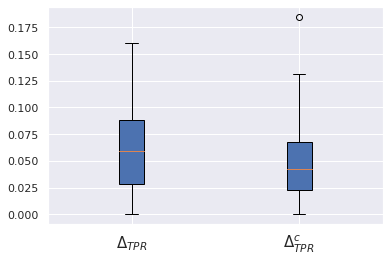

In [49]:
# Difference in TPR pre and post tuning gamma
plt.boxplot(diffs_tpr,patch_artist=True)
plt.xticks([1, 2], [r'$\Delta_{TPR}$', r'$\Delta^c_{TPR}$'])
plt.xticks(fontsize=15)
plt.savefig('Figures/Exp3/better_estimation.png',bbox_inches="tight")

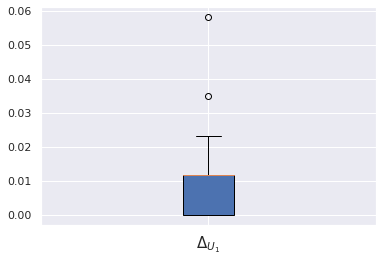

In [50]:
# Difference in U pre and post tuning gamma
plt.boxplot(np.abs(np.array(U1_old) - np.array(U1_new_tpr)),patch_artist=True)
plt.xticks([1], [r'$\Delta_{U_1}$'])
plt.xticks(fontsize=15)
plt.savefig('Figures/Exp3/deltaU.png',bbox_inches="tight")